# Introduction

Asch writes

> The quantitative results are clear and unambiguous.

Our goal for today is to figure out how to interpret this sentence. As we discussed last time, quantitive results do not mean anything in the absence of a model. Most likely, Asch has an implicit, undescribed model in mind when we writes those words. But we can do better - developing several explicit models that allow more rigorous assessment of the data. This process will also showcase the power of our modeling workflow. In the first unit, we built up the workflow very slowly over many classes. Now we'll get through the whole thing in one lecture. So this class will be intense but the payoff is an illustration of everything we've learned so far. The main new topics will be models of heterogeneity. Often times, we think that some experimental intervention should effect different people differently. Maybe our experiment works on some people but not others. In those cases, we say the effectiveness of our intervention is heterogeneous. Our stock binomial distribution fails in these cases. It assumes each person in the experiment has the same underlying accuracy. We'll introduce the beta-binomial as a way of tackling these problems.

# Setting up the problem

All the code in the below section was covered in Lecture 11. Just run these cells so everything is ready to go.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

url = "https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Asch_experiment_1_data"
# url = r"C:\Users\dsaun\github_projects\cogs-303\Asch_experiment_1_data" # local path - ignore this

d = pd.read_csv(url)
d

,treatment,mistakes
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
82,0,0
83,0,0
84,0,0
85,0,1


<BarContainer object of 13 artists>

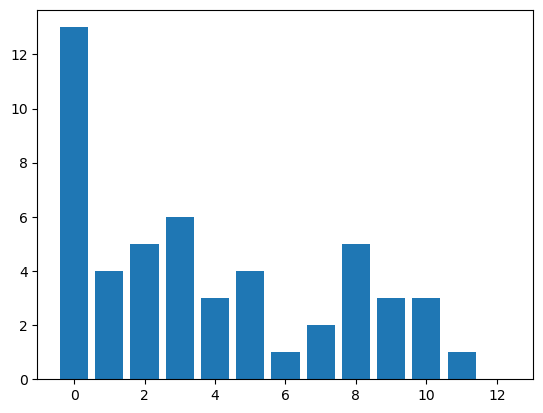

In [7]:
d_treatment = d[d.treatment == 1]
mistakes_treatment = list(d_treatment.mistakes.values)
n_treatment = (50 * 12)
k_treatment = sum(d_treatment.mistakes.values)

# counting structure

outcomes = range(13)
counts = []
    
for i in outcomes:

    matches = mistakes_treatment.count(i)
    counts.append(matches)
    
# plotting structure

plt.bar(outcomes,counts)

<BarContainer object of 13 artists>

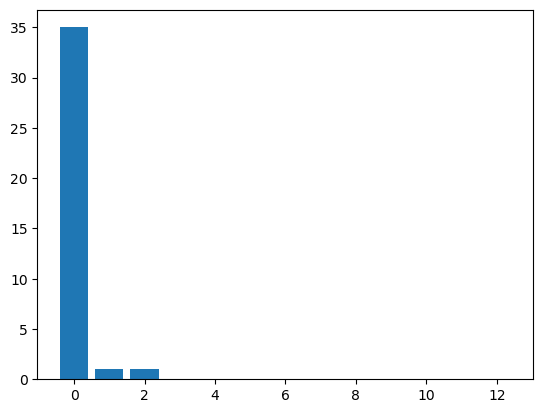

In [58]:
d_control = d[d.treatment == 0]
mistakes_control = list(d_control.mistakes.values)
n_control = (37 * 12)
k_control = sum(d_control.mistakes.values)

# counting structure

outcomes = range(13)
counts = []
    
for i in outcomes:

    matches = mistakes_control.count(i)
    counts.append(matches)

plt.bar(outcomes,counts)

We ended with a bayesian estimation over each binomial distribution:

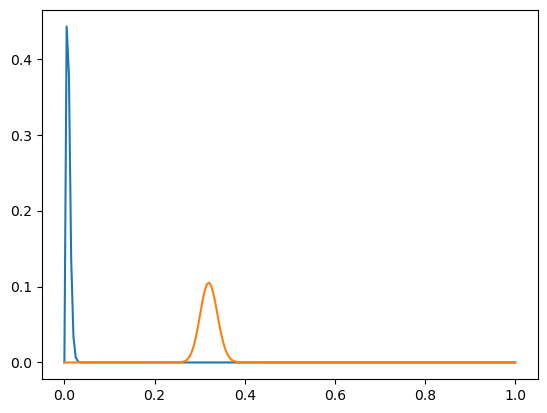

In [102]:
grain = 200

grid = np.linspace(0,1,grain)
prior = np.ones(grain) / grain

# treatment

likelihoods = stats.binom(n=n_treatment,p=grid).pmf(k_treatment)
post_unnormalized = likelihoods * prior
post_treatment = post_unnormalized / sum(post_unnormalized)

# control

likelihoods = stats.binom(n=n_control,p=grid).pmf(k_control)
post_unnormalized = likelihoods * prior
post_control = post_unnormalized / sum(post_unnormalized)

plt.plot(grid,post_control)
plt.plot(grid,post_treatment)

# How to compare two groups

The above plots give the impression that the two groups are *very* different. This supports Asch's claim that the results are unambiguous. The estimated error rates for both groups do not overlap. However, interpreting parameters in the abstract can be hard. What is often more useful is to look at what our estimated models would predict about future experiments. Imagine that we had reran the experiment with 1 million people in the treatment group and control group. How often would they make mistakes? How would their mistakes compare?

The **bad** way to answer this question is to just eyeball the peak of posterior distribution and stick it into the binomial distribution.

In [108]:
stats.binom(p=0.33,n=12).rvs(1000000)

array([6, 5, 3, ..., 3, 3, 3], dtype=int64)

The reason it is bad is that it ignores our uncertainty in that estimate. Although 0.33 is our best guess for the error rate, we are pretty unsure. What would be **better** is if we could sample out parameter values according to your posterior distribution.

In [110]:
samples_params_treatment = np.random.choice(grid,p=post_treatment,size=1000000)
samples_params_treatment

array([0.30150754, 0.34170854, 0.3718593 , ..., 0.28643216, 0.32160804,
       0.29648241])

And then pass these parameters into the binomial distribution to get predictions.

In [116]:
sample_outcome_treatment = stats.binom(p=sample_params_treatment,n=12).rvs()
sample_outcome_treatment

array([5, 6, 3, ..., 4, 1, 4], dtype=int64)

Plotting it lets us see how often our predicted people should make errors.

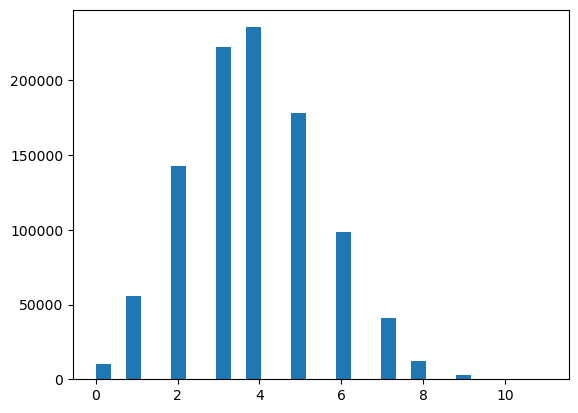

In [119]:
plt.hist(sample_outcome_treatment,bins=30);

Okay that's one group. But let's compare both groups. The strategy here is to see ask "how often should the treatment group people make *more* mistakes than the control group people?" We'll generate 1 million predictions for both groups and then just substract the two sets of predictions.

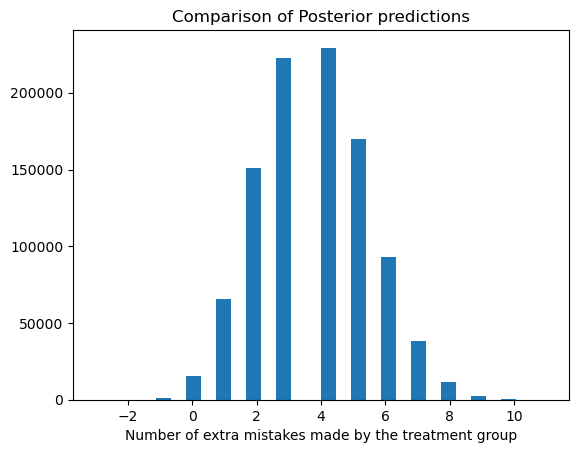

In [123]:
sample_params_control = np.random.choice(grid,p=post_control,size=1000000)
sample_params_treatment = np.random.choice(grid,p=post_treatment,size=1000000)

sample_outcome_control = stats.binom(p=sample_params_control,n=12).rvs()
sample_outcome_treatment = stats.binom(p=sample_params_treatment,n=12).rvs()

diffs = sample_outcome_treatment - sample_outcome_control

plt.hist(diffs,bins=30)
plt.title("Comparison of Posterior predictions")
plt.xlabel("Number of extra mistakes made by the treatment group");

Here's how to interpret this graph. The tall bars in the middle tell us, typically, the treatment group should make 4 more mistakes than the treatment group. On the far right, we see that sometimes, the treatment group should make 10 more mistakes than the control. But, surprising, about 1% of the time, the two groups have the same number of mistakes or the control makes more mistakes.

In [124]:
sum(diffs <= 0) / 1000000

0.016822

This suggests that the data is just a *little* bit more ambiguous than Asch thought. It's possible that, on future experiments, the treatment group does just as well as the control group. We should expect it about 1.7% of the time. Not a huge amount. But we'll keep an eye on this number.

# Doing better than the binomial model

Last class we noted that the application of the binomial distribution to this problem is sustained by two two assumptions:

1. Each person in a group (treatment or control) has the same accuracy level
2. The accuracy levels stay constant over the course of the experiment.

Making these assumptions was mostly just for convenience so we could have a baseline model. We've already thought a lot about how to modify #2 in unit 1. But #1 is a really obviously bad assumption. Asch tells us as much:

> We found evidence of extreme individual differences. There were
in the critical group subjects who remained independent without exception, and there were those who went nearly all the time with the
majority.

What is more, he presents some interview evidence to help us develop a theory about why people conform or remain independent. This sort of qualitative data is extremely useful even when we are doing quantitative research. It helps guide our selection of models. Just like we should incorporate background information into prior distributions, we should incorporate background information into our choice of model too.

Let's try to develop a new model. In this model, people will be of two types. The first type are the independents. They rarely conform. The second type are the conformists who usually conform. The model will work in two steps. First it will randomly decide whether a person is a conformist or an independent. Then it will calculate now many errors that person makes during the experiment. 

The code turns out to be quite tidy:

In [129]:
def simulate_experiment(rate_of_independents=0.60,independents_p=0.05,conformist_p=0.5,n=12,precision=100):
    '''
    rate_of_independents - what proportion of the subjects should be independents, the rest are
        conformists
    independents_p - the probability of a mistake from an independent
    conformist_p - the probability of a mistake from a conformist
    n - the number of critical trials in the experiment
    precision - the number of simulated people 
    '''

    data = []

    for i in range(precision):
        
        # decide whether they are independent or conformist
        
        if np.random.choice([1,0],p=[rate_of_independents, 1-rate_of_independents]) == 1:
            
            # they are an independent
            # then their errors come from a binomial
            # with a very low error rate
            
            errors = stats.binom(p=independents_p,n=n).rvs()
            
        else:
            
            # they are a conformist
            # then their errors come from a binomial
            # with a high error rate

            errors = stats.binom(p=conformist_p,n=n).rvs()
            
        data.append(errors)

    return data

data = simulate_experiment(rate_of_independents=0.60,independents_p=0.05,conformist_p=0.5,n=12,precision=100)
np.array(data)

array([ 7,  7,  0,  6,  1,  0,  2,  0,  4,  4,  6,  8,  1,  7,  0,  2,  6,
        1,  6,  0,  5,  1,  5,  0,  5,  0,  5,  0,  0,  1,  5,  0,  0,  0,
        1,  2,  6,  7,  0,  2,  1,  0,  8,  0,  1,  0,  6,  1,  6,  5,  0,
        2,  6,  3,  1,  0,  0,  1,  0,  1,  1,  0,  0,  1,  1,  7,  4,  0,
        6,  0,  0,  1,  0,  9,  1,  1,  3,  1,  5,  5,  0, 10,  4,  0,  1,
        1,  0,  0,  0,  5,  9,  1,  9,  1,  6,  0,  1,  1,  1,  6])

We can simulate to produce hypothetical experiments. This array depicts how many mistakes each of 100 people made. 

Below, I simulate 1000 people and make a plot. This shows the general probability distribution from this sort of model. I want you to take a minute to play with all the parameters. What does it look like each parameter does to the shape of the graph?

<BarContainer object of 13 artists>

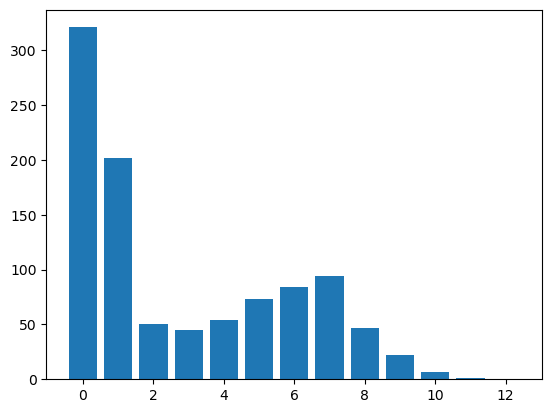

In [130]:
data = simulate_experiment(rate_of_independents=0.60,independents_p=0.05,conformist_p=0.5,n=12,precision=1000)

# counting structure

outcomes = range(13)
counts = []
    
for i in outcomes:

    matches = data.count(i)
    counts.append(matches)
    
# plotting structure

plt.bar(outcomes,counts)

The technical name for this distribution is a *mixture*. It's a mixture of two binomial distributions. You define two binomials with the two `p` parameters. Then you specify the rate of mixing with the `rate_of_independents` parameter.

You'll notice that this produces a much closer match to the observed data. It also makes more sense than the binomial. There are two problems:

1) Estimation. This model has three adjustable parameters, the two `p`s and the rate of mixing. We don't have a technique for estimating three adjustable parameters at once. And it turns out the techniques that do work are quite tricky to implement. I'll link to my [favourite video on monte carlo markov chains](https://www.youtube.com/watch?v=Qqz5AJjyugM) for the keen students who wants to know about where this class could has gone but didn't.

2) Why stop at two groups? Asch gives us some evidence that there might be as many as 6 kinds of people in the experiment. He notes 3 kinds of people who are independent based on interview evidence and 3 kinds of conformists. Should we assume all conformists have the same error rates or three seperate error rates? Frankly, I'm not sure.

There is another, very similar type of model that solves both problems at once. It only has two parameters and represents a broader range of heterogeneity.

# A beta-binomial model

Instead of sorting people into two groups, let's think about a different way of manipulating the `p` of each person. Imagine that, right before each person goes through the experiment, their error rate is drawn from a bag. We might pull out 0.05. That person will make very few errors. The next person shows up and we pull out 0.2. That person will make more errors. Then we pull out 0.15. That person will make a medium amount and so one.

If we could include a model of how error rates are distributed in the bag, then we have all the information we need. Now we already have a good probability distribution for numbers between 0 and 1, it's the beta distribution. I know this this sounds crazy. It is a model stacked on top of another model. If you find this all very abstract, hang on for a minute because it does make some sense soon. 

Let's look at some possible shapes for the beta distribution.

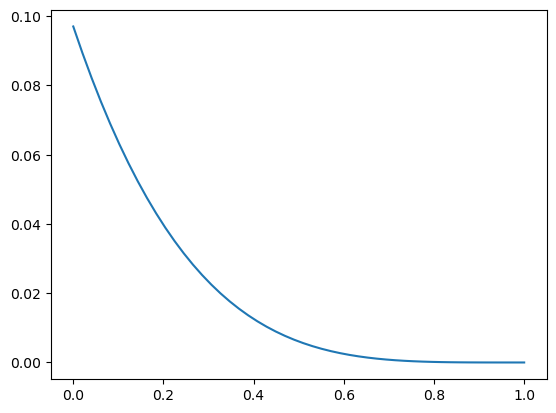

In [36]:
x = np.linspace(0,1)
y = stats.beta(a=1,b=5).pdf(x)
y = y / sum(y)

plt.plot(x,y)

This one suggests that most people have low error rates, a few people have an error rate around 0.6 and almost no one has an error rate of 0.8 or greater.

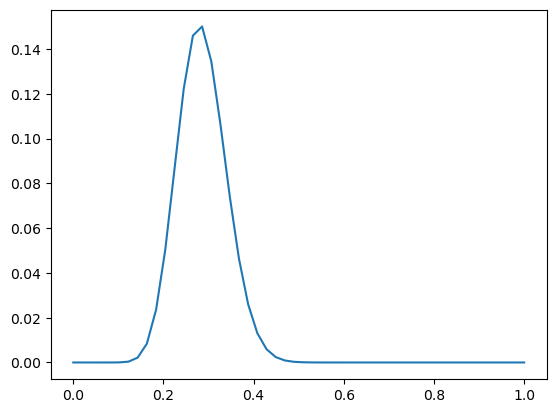

In [148]:
x = np.linspace(0,1)
y = stats.beta(a=20,b=50).pdf(x)
y = y / sum(y)

plt.plot(x,y)

This one suggests that people's error rates tend to fit between 0.2 and 0.4 with most people having an error rate of 0.3. The critical move then, is to sample people's error rates from a beta distribution and then pass that over to a beta distribution. 

<BarContainer object of 13 artists>

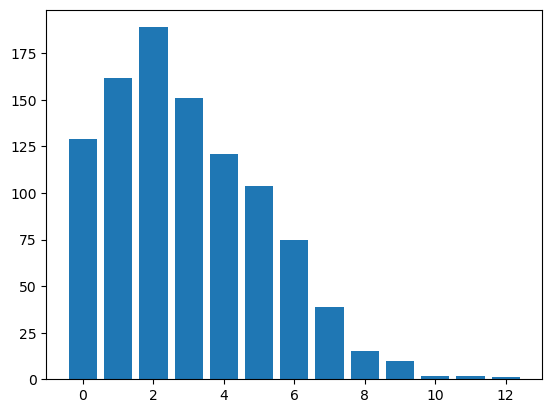

In [42]:
def simulate_experiment(a,b,n=12):

    data = []

    for i in range(1000):
        
        p = stats.beta(a=a,b=b).rvs()
            
        errors = stats.binom(p=p,n=n).rvs()
            
        data.append(errors)

    return data

data = simulate_experiment(a=2,b=6,n=12)
outcomes = range(13)
counts = []
    
for i in outcomes:

    matches = data.count(i)
    counts.append(matches)
    
# plotting structure

plt.bar(outcomes,counts)

Let's draw out the contrast between these two models of hetereogeneity. The first one says: I know how many categories to sort people into. The second one says: lets not sort people into discrete categories. Instead, there is a smooth gradiation of categories and we can control how that gradiation is shaped. Play with the parameters of the beta-binomial for a while to get a feel for it.

## Two ways to think about the parameters of the beta distribution

I must confess that thinking in terms of a and b parameters is pretty hard. There is a mathematical equivalent way of expressing the distribution. We can use two parameters that are a lot easier to think about:

- p = the center
- d = the spread

The way the equivalence works is that `p` controls how much weight is assigned to `a` or `b` and `d` controls how much that weight matters.

$$a = p*d$$
$$b = (1-p)*d$$

So for example, when `d` is very small (like 10 or less) then it is like plugging in small numbers to `a` and `b`. You tend to get very flat distributions and where they concentrate is just controlled by `p`. Below I've plotted the same beta distribution but using both parameterizations of it.

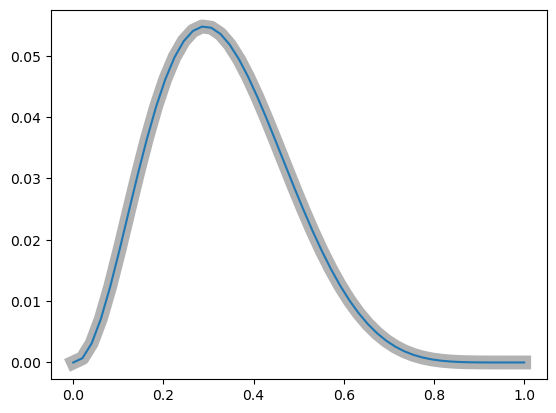

In [165]:
x = np.linspace(0,1)

p = 0.333
d = 10

y1 = stats.beta(a=p*d,b=(1-p)*d).pdf(x)
y1 = y1 / sum(y1)
y2 = stats.beta(a=3.33,b=6.666).pdf(x)
y2 = y2 / sum(y2)

plt.plot(x,y1,'-',linewidth=10,alpha=0.3,color="black")
plt.plot(x,y2,'-')

When `d` is very big, then it's like putting in very big values for `a` and `b`. You get skinny distributions.

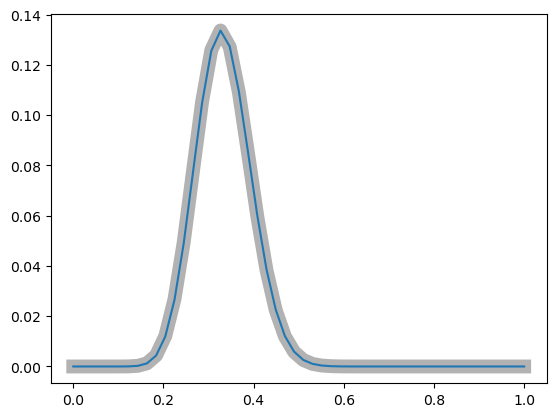

In [166]:
x = np.linspace(0,1)

p = 0.333
d = 60

y1 = stats.beta(a=p*d,b=(1-p)*d).pdf(x)
y1 = y1 / sum(y1)
y2 = stats.beta(a=20,b=40).pdf(x)
y2 = y2 / sum(y2)

plt.plot(x,y1,'-',linewidth=10,alpha=0.3,color="black")
plt.plot(x,y2,'-')

The beta-binomial distribution solves both our problems with the two category mixture model. First, it only has two parameters. Moreover, `scipy.stats` has a convenient function available so we can make our estimation go fast. Second, it doesn't assume a fixed number of groups. Here is an example of how the `stats.betabinom` distribution works.

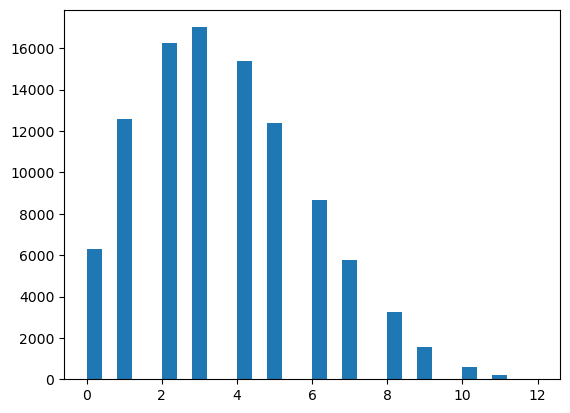

In [170]:
p = 0.3
d = 10
p = stats.betabinom(a=p*d,b=(1-p)*d,n=12).rvs(100000)
plt.hist(p,bins=30);

# Bayesian estimation

So to review where we are at: we've developed and thrown out a couple of distributions now. We don't think the binomial distribution is adequate. Nor do we think the mixture model is adequate. But the beta-binomial is promising. Let's estimate the parameters of this model.

The new challenge is that we have two parameters: `p` and `d`. We can easily construct a grid for both values and get a posterior over either of them. But what we *really* care about is getting a sense 

In [136]:
p_grid = np.linspace(0.01,0.99,200)
d_grid = np.linspace(2,300,200)

p_prior = np.ones(200) / 200
d_prior = stats.norm(80,60).pdf(d_grid)
d_prior = d_prior / sum(d_prior)

<AxesSubplot: >

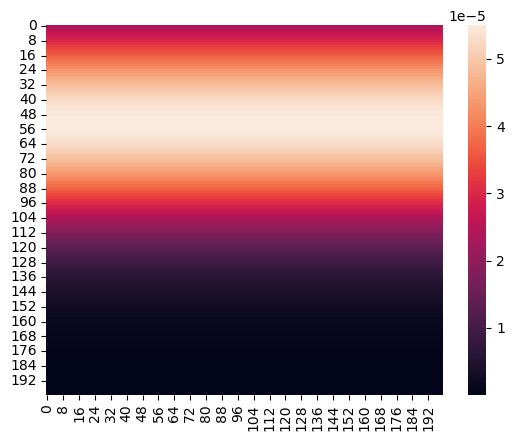

In [137]:
import seaborn as sns

prior_table = []
for d in d_prior:
    prior_row = p_prior * d
    prior_table.append(prior_row)
    
prior_table = np.array(prior_table)
sns.heatmap(prior_table)

<AxesSubplot: >

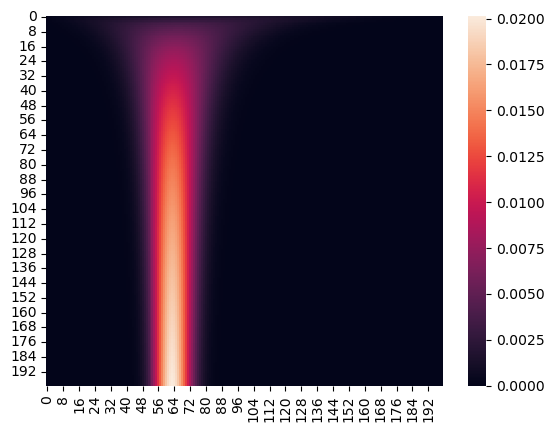

In [138]:
# fast rows technique

likelihoods_table = []
for d in d_grid:
               
    likelihood_row = stats.betabinom(n=n_treatment,a=p_grid*d,b=(1-p_grid)*d).pmf(k_treatment)
    likelihoods_table.append(likelihood_row)
    
likelihoods_table = np.array(likelihoods_table)
sns.heatmap(likelihoods_table)

<AxesSubplot: >

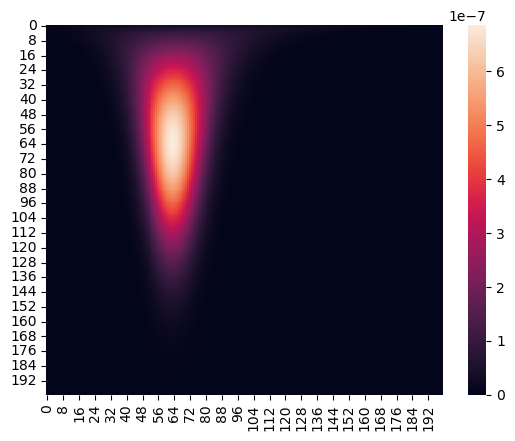

In [139]:
unnormalized_posterior = prior_table * likelihoods_table
sns.heatmap(unnormalized_posterior)

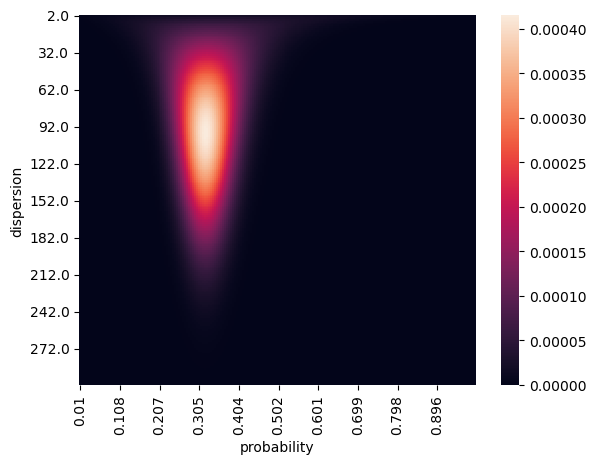

In [140]:
post = pd.DataFrame(unnormalized_posterior,columns=np.round(p_grid,3),index=np.round(d_grid,0)) 
expectation = post.values.sum()
post_treatment = post / expectation

sns.heatmap(post_treatment,xticklabels=20,yticklabels=20)
plt.xlabel("probability")
plt.ylabel("dispersion");

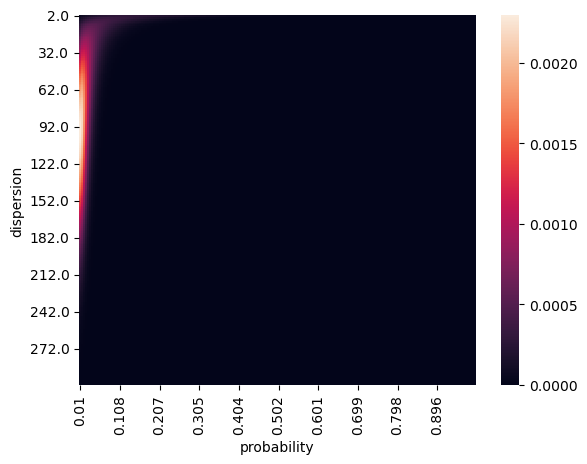

In [141]:
likelihoods_table = []
for d in d_grid:
               
    likelihood_row = stats.betabinom(n=n_control,a=p_grid*d,b=(1-p_grid)*d).pmf(k_control)
    likelihoods_table.append(likelihood_row)
    
likelihoods_table = np.array(likelihoods_table)
unnormalized_posterior = prior_table * likelihoods_table
post = pd.DataFrame(unnormalized_posterior,columns=np.round(p_grid,3),index=np.round(d_grid,0)) 
expectation = post.values.sum()
post_control = post / expectation

sns.heatmap(post_control,xticklabels=20,yticklabels=20)
plt.xlabel("probability")
plt.ylabel("dispersion");

# Comparing groups

In [142]:
p_treatment = post_treatment.sum(axis=0).values
d_treatment = post_treatment.sum(axis=1).values
p_control = post_control.sum(axis=0).values
d_control = post_control.sum(axis=1).values

outcomes = np.arange(0,n_treatment)

sample_p_params_control = np.random.choice(p_grid,p=p_control,size=1000000)
sample_d_params_control = np.random.choice(d_grid,p=d_control,size=1000000)
sample_p_params_treatment = np.random.choice(p_grid,p=p_treatment,size=1000000)
sample_d_params_treatment = np.random.choice(d_grid,p=d_treatment,size=1000000)

In [143]:
sample_outcome_control = stats.betabinom(n=12,a=sample_p_params_control*sample_d_params_control,b=(1-sample_p_params_control)*sample_d_params_control).rvs()
sample_outcome_treatment = stats.betabinom(n=12,a=sample_p_params_treatment*sample_d_params_treatment,b=(1-sample_p_params_treatment)*sample_d_params_treatment).rvs()

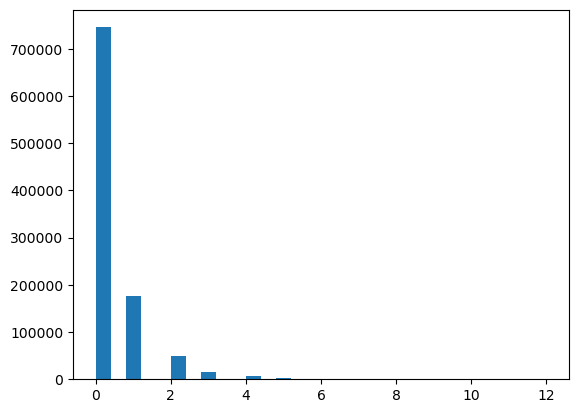

In [144]:
plt.hist(sample_outcome_control,bins=30);

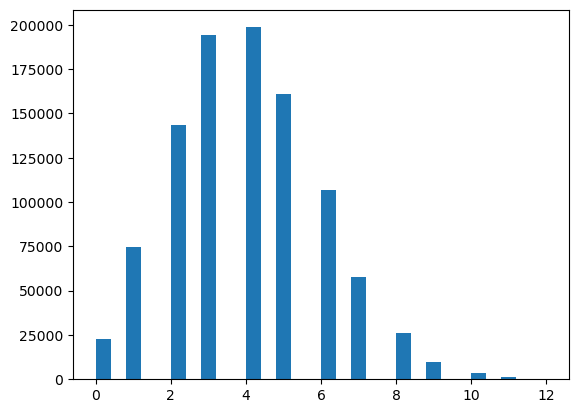

In [145]:
plt.hist(sample_outcome_treatment,bins=30);

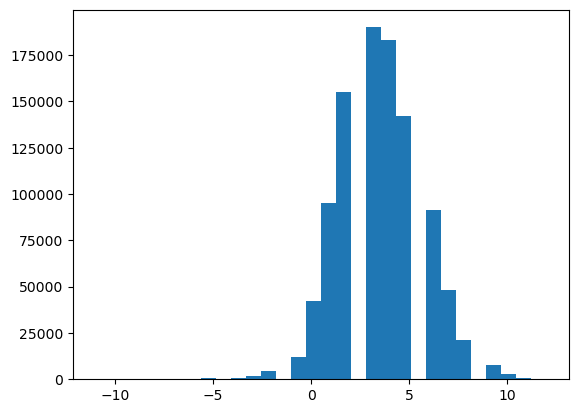

In [146]:
diffs = sample_outcome_treatment - sample_outcome_control

plt.hist(diffs,bins=30);

In [147]:
sum(diffs <= 0) / 1000000

0.062103